In [1]:
import tensorflow as tf

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [3]:
import numpy as np
import os
import sys
import pandas as pd
import split_extract
import matplotlib.pyplot as plt
from tqdm import tqdm
from multiprocessing import Pool
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from params import dresden_images_root, images_db_path, patch_span, \
        patch_num, patches_root, patches_db_path, compr_root, compr_img, compr_patches

In [4]:
if not os.path.exists(compr_root):
    os.makedirs(compr_root)
if not os.path.exists(compr_img):
    os.makedirs(compr_img)
if not os.path.exists(compr_patches):
    os.makedirs(compr_patches)

patches_db = np.load(patches_db_path, allow_pickle=True).item()
images_db = np.load(images_db_path, allow_pickle=True).item()
model_img = dict(zip(images_db['path'], images_db['brand_model']))

model_list = np.unique(images_db['brand_model'])[0:3]
img_list = patches_db['test']
label_list = [model_img[img] for img in img_list]
img_path = [os.path.join(dresden_images_root, img) for img in img_list]
jpg_path = [os.path.join(compr_root, img) for img in img_path]

In [5]:
for img, path in zip(img_path, jpg_path):
    if not os.path.exists(path):          
        im = Image.open(img)
        im.save(path, 'JPEG', quality=70, optimize=True)

In [6]:
print('Collecting image data...')
imgs_list = []

for img_brand_model, img_path in \
    tqdm(zip(label_list, jpg_path)):
        imgs_list += [{'data_set':'patches',
                           'img_path':img_path,
                           'img_brand_model':img_brand_model,
                           'patch_span':patch_span,
                           'patch_num':patch_num,
                           'patch_root': compr_root,
                           'img_root': './'
                           }]
# num_processes = 12
num_processes = 4
pool = Pool(processes=num_processes)

195it [00:00, 172586.89it/s]

In [ ]:
test_paths = pool.map(split_extract.extract, imgs_list)
print('Completed.')

In [8]:
# Define image and batch size
img_height = 256
img_width = 256
batch_size = 64

# Load and Compile the model
model = tf.keras.models.load_model('./instance/model.h5')

sgd = tf.keras.optimizers.SGD(lr=0.001, momentum=0.95, decay=0.0004)

model.compile(
    optimizer=sgd, 
    loss='binary_crossentropy', 
    metrics=['accuracy'])

# Create the Generator
test_data_gen = ImageDataGenerator(preprocessing_function=None,
    rescale=1./255)

# Read the positive test samples.
test_generator = test_data_gen.flow_from_directory(
                  directory = r"./compr/patches/",
                  target_size=(img_width, img_height), color_mode='grayscale', shuffle=True,
                  batch_size=batch_size, class_mode="categorical")

print('\n# Evaluate on test data')
results = model.evaluate(test_generator)

Found 4700 images belonging to 3 classes.

# Evaluate on test data
74/74 [==============================] - 13s 182ms/step - loss: 4.4608 - accuracy: 0.6965


Found 4700 images belonging to 3 classes.
                     Canon_Ixus55  Canon_Ixus70  Canon_PowerShotA640
Canon_Ixus55                    6          1175                    1
Canon_Ixus70                    0          2442                    0
Canon_PowerShotA640             0           852                    4


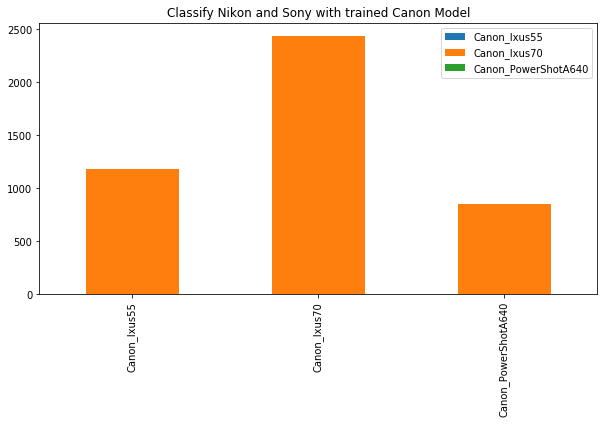

In [9]:
test_data_gen = ImageDataGenerator(preprocessing_function=None,
    rescale=1./255)
# Read the positive test samples.
test_generator = test_data_gen.flow_from_directory(
                  directory = r"./compr/patches/",
                  target_size=(img_width, img_height), color_mode='grayscale', shuffle=True,
                  batch_size=batch_size, class_mode="categorical")

# generate a histogram, which for every unseen models, how many imgs are classified.
hist = [[0, 0, 0] for i in range(len(model_list))]

for i in range(70):
    gen = next(test_generator)
    pred = model.predict(gen[0])
    pred_labels = np.argmax(pred, axis=1)
    real_labels = np.argmax(gen[1], axis=1)
    for j in range(len(pred_labels)):
        hist[real_labels[j]][pred_labels[j]] += 1
        
df = pd.DataFrame(hist, index=model_list, columns=model_list)
print(df)

df.plot.bar(stacked=True, figsize=(10, 5), title='Classify Nikon and Sony with trained Canon Model')